In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import keras.regularizers as regularizers
from keras.regularizers import l2

In [3]:
import os
import shutil
import numpy as np

# the base directory
base_dir = '/content/drive/MyDrive/datasets/Cervical cancer image dataset'

# directories for training, validation, and testing
train_dir = '/content/data/train'
val_dir = '/content/data/validation'
test_dir = '/content/data/test'

# subdirectories for each class in each set
classes = ['High squamous intra-epithelial lesion', 'Low squamous intra-epithelial lesion', 'Negative for Intraepithelial malignancy', 'Squamous cell carcinoma']

for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Spliting the data
def split_data(base_dir, train_dir, val_dir, test_dir, classes, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        files = os.listdir(cls_dir)
        np.random.shuffle(files)

        train_count = int(len(files) * train_ratio)
        val_count = int(len(files) * val_ratio)

        train_files = files[:train_count]
        val_files = files[train_count:train_count + val_count]
        test_files = files[train_count + val_count:]

        for f in train_files:
            shutil.copy(os.path.join(cls_dir, f), os.path.join(train_dir, cls, f))

        for f in val_files:
            shutil.copy(os.path.join(cls_dir, f), os.path.join(val_dir, cls, f))

        for f in test_files:
            shutil.copy(os.path.join(cls_dir, f), os.path.join(test_dir, cls, f))

split_data(base_dir, train_dir, val_dir, test_dir, classes)


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image data generator without data augmentation
datagen = ImageDataGenerator(rescale=1./255)

# data generators
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 673 images belonging to 4 classes.
Found 189 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [ ]:
import os
from PIL import Image

def get_image_shapes_and_labels(base_dir):
    data = {}
    for split in ['train', 'validation', 'test']:
        data[split] = []
        split_dir = os.path.join(base_dir, split)
        for class_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    try:
                        with Image.open(img_path) as img:
                            shape = img.size  # (width, height)
                            data[split].append({'path': img_path, 'label': class_name, 'shape': shape})
                    except Exception as e:
                        print(f"Error reading {img_path}: {e}")
    return data

base_dir = '/content/data'
image_data = get_image_shapes_and_labels(base_dir)

# Print a summary
for split, images in image_data.items():
    print(f"{split.upper()}: {len(images)} images")
    for img_info in images[:5]:  # Print first 5 images info
        print(img_info)

Error reading /content/data/train/Negative for Intraepithelial malignancy/Results.csv: cannot identify image file '/content/data/train/Negative for Intraepithelial malignancy/Results.csv'
TRAIN: 672 images
{'path': '/content/data/train/Negative for Intraepithelial malignancy/NL_35_ (15).jpg', 'label': 'Negative for Intraepithelial malignancy', 'shape': (2048, 1536)}
{'path': '/content/data/train/Negative for Intraepithelial malignancy/NL_16_ (9).jpg', 'label': 'Negative for Intraepithelial malignancy', 'shape': (2048, 1536)}
{'path': '/content/data/train/Negative for Intraepithelial malignancy/NL_43_ (9).jpg', 'label': 'Negative for Intraepithelial malignancy', 'shape': (2048, 1536)}
{'path': '/content/data/train/Negative for Intraepithelial malignancy/NL_7_ (10).jpg', 'label': 'Negative for Intraepithelial malignancy', 'shape': (2048, 1536)}
{'path': '/content/data/train/Negative for Intraepithelial malignancy/NL_36_ (13).jpg', 'label': 'Negative for Intraepithelial malignancy', 'shap

In [7]:
from tensorflow.keras.layers import BatchNormalization


base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


# Add your custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x) we can add dropouts if model is overfitting
x = Flatten()(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalization_94[0

In [18]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss',verbose=1, patience=5, restore_best_weights=True),
             ModelCheckpoint('best_model.h5',verbose=1, monitor='val_loss', save_best_only=True)]

In [19]:
history = model.fit (
    train_generator,
    epochs =25,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/25
22/22 [==============================] - ETA: 0s - loss: 1.3908 - accuracy: 0.3715
Epoch 1: val_loss improved from inf to 1.31551, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 73s 3s/step - loss: 1.3908 - accuracy: 0.3715 - val_loss: 1.3155 - val_accuracy: 0.3704
Epoch 2/25
22/22 [==============================] - ETA: 0s - loss: 0.8384 - accuracy: 0.6924
Epoch 2: val_loss improved from 1.31551 to 0.88453, saving model to best_model.h5
22/22 [==============================] - 51s 2s/step - loss: 0.8384 - accuracy: 0.6924 - val_loss: 0.8845 - val_accuracy: 0.7831
Epoch 3/25
22/22 [==============================] - ETA: 0s - loss: 0.6249 - accuracy: 0.7920
Epoch 3: val_loss improved from 0.88453 to 0.68891, saving model to best_model.h5
22/22 [==============================] - 46s 2s/step - loss: 0.6249 - accuracy: 0.7920 - val_loss: 0.6889 - val_accuracy: 0.8201
Epoch 4/25
22/22 [==============================] - ETA: 0s - loss: 0.4541 - accuracy: 0.8722
Epoch 4: val_loss improved from 0.68891 to 0.56591, saving model to best_model.h5
22/22 [==============================] - 49s 2s/step - loss: 0.4541 - accuracy: 0.872

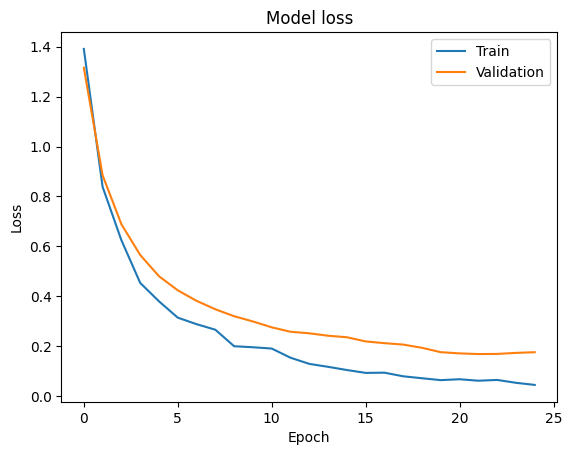

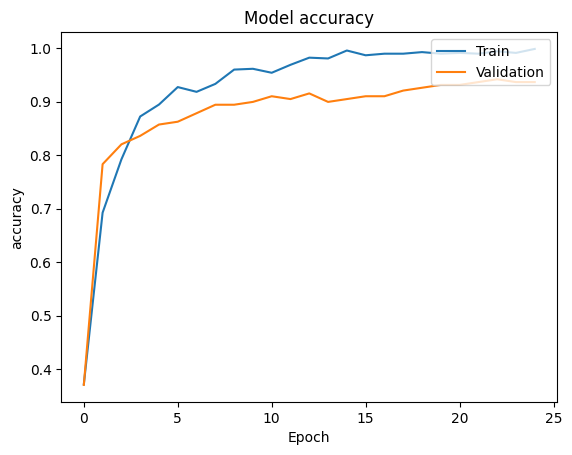

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [23]:
train_loss, train_accuracy = model.evaluate(train_generator)

print(f'Train accuracy: {train_accuracy:.4f}')

22/22 [==============================] - 36s 2s/step - loss: 0.0150 - accuracy: 1.0000
Train accuracy: 1.0000


In [24]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test accuracy: {test_accuracy:.4f}')

4/4 [==============================] - 5s 1s/step - loss: 0.2208 - accuracy: 0.9200
Test accuracy: 0.9200


4/4 [==============================] - 6s 1s/step


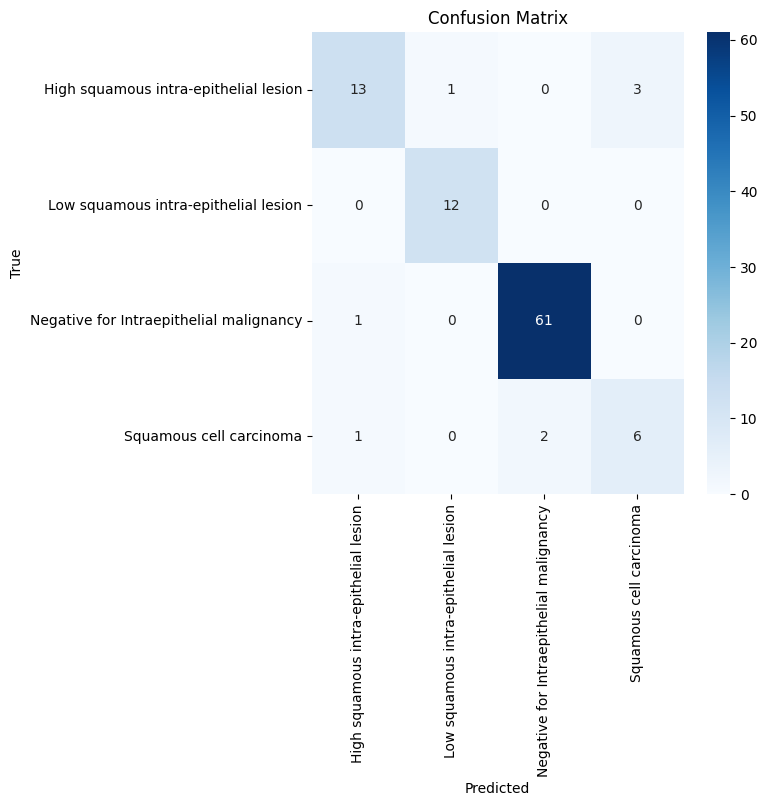

                                     Class  Precision    Recall  F1 Score
0    High squamous intra-epithelial lesion   0.866667  0.764706  0.812500
1     Low squamous intra-epithelial lesion   0.923077  1.000000  0.960000
2  Negative for Intraepithelial malignancy   0.968254  0.983871  0.976000
3                  Squamous cell carcinoma   0.666667  0.666667  0.666667


In [22]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Make Predictions
y_pred = model.predict(test_generator)

# Convert Predictions and True Labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

# Create the Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)


# Create a dictionary to map class indices to class names
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}


# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Create a list of class names
class_names_list = [class_names[i] for i in range(len(class_indices))]

# Create a DataFrame to organize the results
results_df = pd.DataFrame({
    'Class': class_names_list,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Print the results table
print(results_df)


In [25]:
from tensorflow.keras.applications import ResNet50

base_model2 = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x= base_model2.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model2 = Model(inputs=base_model2.input, outputs=predictions)

94765736/94765736 [==============================] - 5s 0us/step


In [30]:
base_model2.trainable = True

set_trainable = False

for layer in base_model2.layers:
  if layer.name == 'conv4_block1_preact_bn':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [31]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [32]:
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss',verbose=1, patience=5, restore_best_weights=True),
             ModelCheckpoint('best_model.h5',verbose=1, monitor='val_loss', save_best_only=True)]

In [34]:
history2 = model2.fit (
    train_generator,
    epochs =25,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/25
22/22 [==============================] - ETA: 0s - loss: 1.1241 - accuracy: 0.5453
Epoch 1: val_loss improved from inf to 1.23588, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 52s 2s/step - loss: 1.1241 - accuracy: 0.5453 - val_loss: 1.2359 - val_accuracy: 0.6402
Epoch 2/25
22/22 [==============================] - ETA: 0s - loss: 0.9424 - accuracy: 0.6360
Epoch 2: val_loss improved from 1.23588 to 1.17684, saving model to best_model.h5
22/22 [==============================] - 47s 2s/step - loss: 0.9424 - accuracy: 0.6360 - val_loss: 1.1768 - val_accuracy: 0.6402
Epoch 3/25
22/22 [==============================] - ETA: 0s - loss: 0.8213 - accuracy: 0.6999
Epoch 3: val_loss improved from 1.17684 to 1.14858, saving model to best_model.h5
22/22 [==============================] - 49s 2s/step - loss: 0.8213 - accuracy: 0.6999 - val_loss: 1.1486 - val_accuracy: 0.6402
Epoch 4/25
22/22 [==============================] - ETA: 0s - loss: 0.7229 - accuracy: 0.7236
Epoch 4: val_loss improved from 1.14858 to 1.11326, saving model to best_model.h5
22/22 [==============================] - 48s 2s/step - loss: 0.7229 - accuracy: 0.723

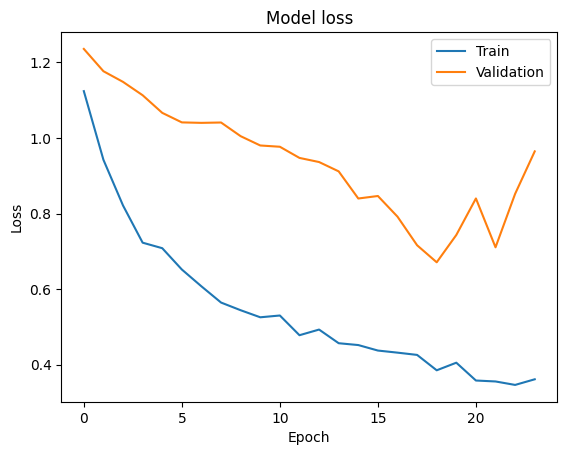

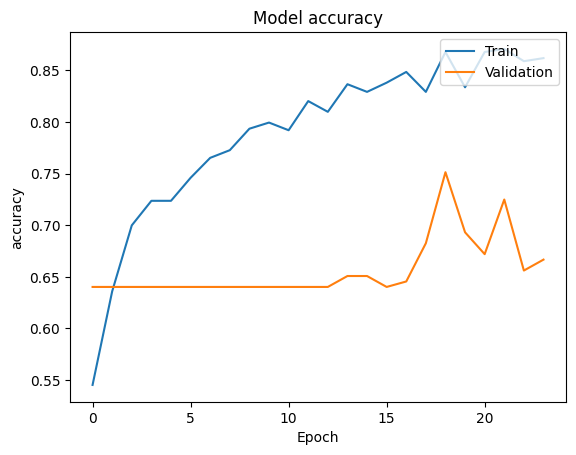

In [38]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [39]:
train_loss, train_accuracy = model2.evaluate(train_generator)

print(f'Train accuracy: {train_accuracy:.4f}')

22/22 [==============================] - 36s 2s/step - loss: 0.6316 - accuracy: 0.8039
Train accuracy: 0.8039


In [40]:
test_loss, test_accuracy = model2.evaluate(test_generator)

print(f'Test accuracy: {test_accuracy:.4f}')

4/4 [==============================] - 6s 1s/step - loss: 0.6783 - accuracy: 0.7300
Test accuracy: 0.7300


4/4 [==============================] - 5s 1s/step


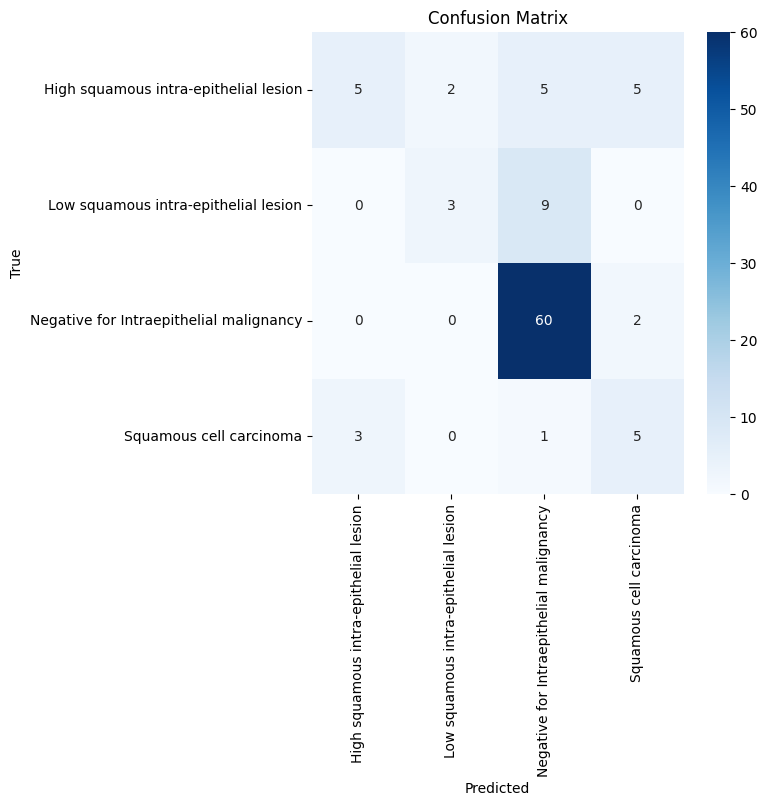

                                     Class  Precision    Recall  F1 Score
0    High squamous intra-epithelial lesion   0.625000  0.294118  0.400000
1     Low squamous intra-epithelial lesion   0.600000  0.250000  0.352941
2  Negative for Intraepithelial malignancy   0.800000  0.967742  0.875912
3                  Squamous cell carcinoma   0.416667  0.555556  0.476190


In [43]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Make Predictions
y_pred2 = model2.predict(test_generator)

# Convert Predictions and True Labels
y_pred_classes2 = np.argmax(y_pred2, axis=1)
y_true_classes2 = test_generator.classes

# Create the Confusion Matrix
cm2 = confusion_matrix(y_true_classes2, y_pred_classes2)


# Create a dictionary to map class indices to class names
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}


# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_true_classes2, y_pred_classes2, average=None)
recall = recall_score(y_true_classes2, y_pred_classes2, average=None)
f1 = f1_score(y_true_classes2, y_pred_classes2, average=None)

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Create a list of class names
class_names_list = [class_names[i] for i in range(len(class_indices))]

# Create a DataFrame to organize the results
results_df = pd.DataFrame({
    'Class': class_names_list,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

# Print the results table
print(results_df)
